In [1]:
!pip install pims av
!python --version

     |████████████████████████████████| 92kB 6.0MB/s 
     |████████████████████████████████| 37.2MB 78kB/s 
  Created wheel for pims: filename=PIMS-0.5-cp37-none-any.whl size=84328 sha256=cafcfef50555d0bc3a2b885b2dcfc5fb89081b50a21bce7f522fcc9fe661b74e
  Stored in directory: /root/.cache/pip/wheels/0e/0a/14/4c33a4cc1b9158e57329a38e8e3e03901ed24060eb322d5462
Successfully built pims
Python 3.7.10


In [2]:
import numpy as np
import cv2
import pims
from tqdm.notebook import trange
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3432448/45929032 bytes (7.5%)7454720/45929032 bytes (16.2%)10674176/45929032 bytes (23.2%)13565952/45929032 bytes (29.5%)17588224/45929032 bytes (38.3%)21594112/45929032 bytes (47.0%)25673728/45929032 bytes (55.9%)29630464/45929032 bytes (64.5%)33390592/45929032 bytes (72.7%)37191680/45929032 bytes (81.0%)40992768/45929032 bytes (89.3%)44998656/45929032 bytes (98.0%)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# CONSTANTS
# network input resolution
W = 320
H = 160

# annotations' resolution
annot_W = 480
annot_H = 320

In [5]:
# DATA FUNCTIONS
from os import listdir

# get polylines from file
def extract_polylines(filename):
  tree = ET.parse(filename)
  polylines = []
  for polyline in tree.iter(tag='polyline'):
    frame = polyline.get("frame")
    points = polyline.get("points").split(";")
    for i in range(len(points)):
      points[i] = points[i].split(",")
      for j in range(len(points[i])):
        points[i][j] = float(points[i][j])
    data = (int(frame), points)
    polylines.append(data)

  return sorted(polylines)

# get polylines from each frame
def extract_frame_lines(polylines):
  n_frames = polylines[-1][0]
  frames = []

  for i in range(n_frames+1):
    frame = []
    for polyline in polylines:
      if polyline[0] == i:
        frame.append(polyline[1])
    frames.append(sorted(frame))
    
  return frames

# convert annotations to new resolution
def convert_annotations(old_res, new_res, annotations):
  W, H = old_res
  new_W, new_H = new_res
  new_annotations = []
  for polylines in annotations:
    new_polylines = []
    for polyline in polylines:
      new_polyline = []
      for point in polyline:
        x, y = point
        new_x = (x*new_W) / W
        new_y = (y*new_H) / H
        new_polyline.append([new_x,new_y])
      new_polylines.append(new_polyline)
    new_annotations.append(new_polylines)
  return np.array(new_annotations)

# get training data from path
def get_data(video_path, annotations_path):
  # get video frames
  frames = pims.Video(video_path, format="mp4")
  
  # get road edges data
  annotations = extract_polylines(annotations_path)
  annotations = extract_frame_lines(annotations)
  annotations = convert_annotations((annot_W,annot_H), (W,H), annotations)

  return frames, annotations

# make pims video into actual numpy frames
def conv_frames(frames):
  imgs = []
  print("Getting frames into proper arrays")
  for frame in frames:
    imgs.append(cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (W,H)))
  print("Frames converted to numpy arrays")
  return np.array(imgs)

base_dir = "/content/drive/MyDrive/OpenCRD_dataset/"
video_files = []
annot_files = []
for f in listdir(base_dir):
  if f.endswith(".mp4"):
    video_files.append(f)
  elif f.endswith(".xml"):
    annot_files.append(f)
video_files, annot_files = sorted(video_files), sorted(annot_files)

video_files = video_files[:3] # TODO: this is a temp hack, need to get all videos' annotations
print(video_files)
print(annot_files)

assert len(video_files) == len(annot_files), "Number of video files != number of annotation files"

['city_1.mp4', 'city_2.mp4', 'city_3.mp4']
['city_1_annotations.xml', 'city_2_annotations.xml', 'city_3_annotations.xml']


In [10]:
# PYTOCH MODEL
# model for road edge detection
class REDetector(nn.Module):
  def __init__(self):
    super(REDetector, self).__init__()

    # output polylines attributes
    self.n_coords = 2  # 2 coordinates: x,y
    self.n_points = 4  # number of points of each polyline
    self.max_n_lines = 6 # max number of polylines per frame

    # Convolutional Layers 
    # NOTE: in order to multitask-learn with CRDetector (conv layers will be the same since they sohould detect the same features), this part should not be changed
    # TODO: change this architecture (ResNet)
    self.conv1 = nn.Conv2d(3, 16, 5)
    self.conv2d_bn1 = nn.BatchNorm2d(16)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.conv2d_bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, 5)
    self.conv4 = nn.Conv2d(64, 128, 3)
    self.conv5 = nn.Conv2d(128, 256, 3)

    # Fully Connected Layers
    self.dropout1 = nn.Dropout(0.1)
    self.fc1 = nn.Linear(256*14*34, 2048) # for 320x160 image 256 channels
    self.fc2 = nn.Linear(2048, 1024)
    self.fc3 = nn.Linear(1024, 256)
    self.fc4 = nn.Linear(256, 96)
    self.dropout2 = nn.Dropout(0.5)
    self.fc5 = nn.Linear(96, self.n_coords*self.n_points*self.max_n_lines)

  def forward(self, x):
    x = self.pool(F.relu(self.conv2d_bn1(self.conv1(x))))
    x = self.pool(F.relu(self.conv2d_bn2(self.conv2(x))))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.pool(F.relu(self.conv5(x)))
    #print(x.shape)
    # TODO: relu doesnt allow negative values, try to mix it up with tanh (first or last FC layers) as well as relu
    x = x.view(-1, self.num_flat_features(x))
    x = self.dropout1(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = torch.tanh(self.fc4(x))
    x = self.dropout2(x)
    x = self.fc5(x)

    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

In [8]:
# ANNOTATIONS TRANSFORMATIONS

# TODO: this algorithm has bad complexity (O(n^3)), refactor if possible
# convert polylines per frame to net output vector (flattens the array)
def serialize_polylines(polylines, n_coords, n_points, max_n_lines):
  # check if we have more than n_points
  # TODO: instead of removing the whole line, just get polyline[:n_points]
  for polyline in polylines:
    if len(polyline) != n_points:
      polylines.remove(polyline)
  assert len(polylines) <= max_n_lines, "More than max number of lines found"

  # fill the gaps with negative values (-1 == NULL => out of bounds)
  if len(polylines) < max_n_lines:
    for i in range(max_n_lines - len(polylines)):
      new_polyline = []
      for j in range(n_points):
        point = []
        for k in range(n_coords):
          point.append(-1.0)
        new_polyline.append(point)
      polylines.append(new_polyline)
      
  # flatten
  ret = []
  for i in range(max_n_lines):
    for j in range(n_points):
      for k in range(n_coords):
        ret.append(polylines[i][j][k])

  return np.array(ret)

# TODO: this needs more work depending on the net output, since it is tested only on annotations
# convert network output vector to polylines per frame
def deserialize_polylines(net_output, n_coords, n_points, max_n_lines):
  polylines = []
  point = []
  line = []
  for i in range(len(net_output)):
    point.append(net_output[i])
    if len(point) == 2:
      line.append(point)
      point = []
    if len(line) == 4:
      polylines.append(line)
      line = []

  # remove (-1, -1)/out-of-bounds points from lines
  for polyline in polylines:
    while [-1., -1.] in polyline:
      polyline.remove([-1., -1.]) # TODO: remove all negative numbers, not just (-1., -1.) pairs

  # remove empty lists
  while [] in polylines:
    polylines.remove([])

  return np.array(polylines)

In [ ]:
# test the above functions (this will be later used on the training loop for Y_train)
n_coords = 2  # 2 coordinates: x,y
n_points = 4  # number of points of each polyline
max_n_lines = 6 # max number of polylines per frame

frames, annotations = get_data(base_dir+video_files[2], base_dir+annot_files[2])

idx = 0
for polylines in annotations:
  ret = serialize_polylines(polylines, n_coords, n_points, max_n_lines)
  print("++++++++++")
  print("Frame", idx)
  print(ret)
  print("==========")
  new_polylines = deserialize_polylines(ret, n_coords, n_points, max_n_lines)
  print(new_polylines)
  idx += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Streaming output truncated to the last 5000 lines.

 [[319.96       143.17      ]
  [226.82666667 127.565     ]
  [186.19333333 110.3       ]
  [239.43333333 110.12      ]]]
++++++++++
Frame 758
[  0.         138.13       106.49333333 125.2        136.02666667
 109.03        78.86666667 106.08       319.97333333 143.53
 228.04       128.11       186.30666667 110.4        240.13333333
 110.18        -1.          -1.          -1.          -1.
  -1.          -1.          -1.          -1.          -1.
  -1.          -1.          -1.          -1.          -1.
  -1.          -1.          -1.          -1.          -1.
  -1.          -1.          -1.          -1.          -1.
  -1.          -1.          -1.          -1.          -1.
  -1.          -1.          -1.        ]
[[[  0.         138.13      ]
  [106.49333333 125.2       ]
  [136.02666667 109.03      ]
  [ 78.86666667 106.08      ]]

 [[319.97333333 143.53      ]
  [228.04       128.11      ]
  [186.30666667 110.4       ]
  [240.13333

[~] Cleared cuda cache


[~] Loading from files: /content/drive/MyDrive/OpenCRD_dataset/city_2.mp4 , /content/drive/MyDrive/OpenCRD_dataset/city_2_annotations.xml


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Getting frames into proper arrays
Frames converted to numpy arrays
[~] Loading from files: /content/drive/MyDrive/OpenCRD_dataset/city_3.mp4 , /content/drive/MyDrive/OpenCRD_dataset/city_3_annotations.xml
Getting frames into proper arrays
Frames converted to numpy arrays

[+] Training model ...
[+] Epoch 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([64, 1, 48])) that is different to the input size (torch.Size([64, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)



[+] Epoch 1



[+] Epoch 2



[+] Epoch 3



[+] Epoch 4



[+] Epoch 5



[+] Epoch 6



[+] Epoch 7



[+] Epoch 8



[+] Epoch 9



[+] Epoch 10



tensor([[  1.9737, 136.3939,  70.3501,  ...,  -0.7458,  -2.2660,  -1.7903],
        [  1.0431,  88.4265,  46.1725,  ...,  -0.8806,  -1.6824,  -1.6321],
        [  1.2642, 114.7821,  61.0902,  ...,  -1.0482,  -1.8005,  -1.8977],
        ...,
        [  1.4517, 118.8046,  62.9522,  ...,  -0.8477,  -2.1597,  -1.4595],
        [  1.6508, 129.3059,  68.2873,  ...,  -0.6437,  -2.3041,  -1.8031],
        [  1.7076, 112.7494,  59.4335,  ...,  -1.1247,  -2.2554,  -1.4684]],
       device='cuda:0', grad_fn=<AddmmBackward>)
[+] Trained model on all data files


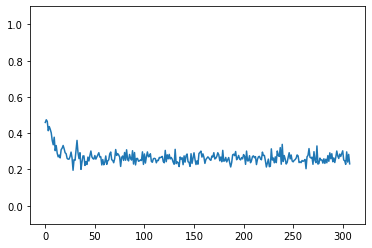

In [37]:
# TRAINING PROCESS
def train(frames, annotations, model):
  loss_function = nn.L1Loss() # mean absolute error
  #loss_function = nn.MSELoss() # mean square error
  optim = torch.optim.Adam(model.parameters(), lr=0.1)  # TODO: try new learning rates (maybe increase the rate)

  losses, accuracies = [], []
  # TODO: try different BS aand epochs
  epochs = 11
  BS = 64

  for epoch in range(epochs):
    print("[+] Epoch", epoch)
    t = trange(0, len(frames)-BS, BS)
    for i in t: 
      # get data into network
      X_train = []
      Y_train = []

      rng = np.random.default_rng()
      samp = rng.choice(len(frames), size=BS, replace=False)
      for j in samp:
        frame = frames[j]
        frame = np.moveaxis(frame, -1, 0) # [batch_size, channels, height, width]
        X_train.append(frame)
        flat_annot = serialize_polylines(annotations[j], model.n_coords, model.n_points, model.max_n_lines)
        Y_train.append([flat_annot])
      
      """
      # NOTE: this might work better here, but it is not compatible with multitask learning
      # without random sample
      for j in range(i, i+BS):
        frame = frames[j]
        frame = np.moveaxis(frame, -1, 0)
        X_train.append(frame)
        flat_annot = serialize_polylines(annotations[j], model.n_coords, model.n_points, model.max_n_lines)
        Y_train.append([flat_annot])
      """
      X = torch.tensor(np.array(X_train)).float().to(device)
      Y = torch.tensor(np.array(Y_train)).float().to(device)

      # TODO: handle accuracy
      # forward and back feed
      optim.zero_grad()
      out = model(X)
      #accuracy = (out == Y).float().mean()  # TODO: this might be wrong
      loss = loss_function(out, Y)
      loss = loss.mean()
      loss.backward()
      optim.step()

      # print stats
      loss = loss.item()
      #accuracy = accuracy.item()
      losses.append(loss/100) # /100 so that we can see it in the graph
      #losses.append(loss/10000) # /10000 so that we can see it in the graph
      #accuracies.append(accuracy)
      #t.set_description("loss %.2f accuracy %.2f out %.2f" % (loss, accuracy, out.mean().item()))
      t.set_description("loss %.2f out %.2f" % (loss, out.mean().item()))

  # plot losses and accuracies
  plt.ylim(-0.1, 1.1)
  plot(losses)
  #plot(accuracies)
  print(out)

  return model

if device.type == "cuda":
  torch.cuda.empty_cache()  # to avoid running out of cuda memory
  print("[~] Cleared cuda cache")

model = REDetector().to(device).train()

for i in trange(1, len(video_files)):
  print("[~] Loading from files: %s , %s" % (base_dir+video_files[i], base_dir+annot_files[i]))
  frames, annotations = get_data(base_dir+video_files[i], base_dir+annot_files[i])
  frames = conv_frames(frames)
  #if i == 0:
  if i == 1:
    all_frames = frames
    all_annotations = annotations
  else:
    all_frames = np.concatenate((all_frames, frames), axis=0)
    all_annotations = np.concatenate((all_annotations, annotations), axis=0)

frames, labels = [], [] # free up memory
print("[+] Training model ...")
model = train(all_frames, all_annotations[:-1], model)
print("[+] Trained model on all data files")

In [ ]:
# TODO: evaluate model
def evalutate(mode, X_test, Y_test):
  pass

In [36]:
# save model for later retraining
def save_model(path, model):
  torch.save(model.state_dict(), path)
  print("Model saved to path", path)
model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/re_detector.pth"
#model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/re_detector_nonrandom.pth"
#model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/re_detector_nonrandom_big.pth"
save_model(model_path, model)

Model saved to path /content/drive/MyDrive/OpenCRD_dataset/models/re_detector_nonrandom_big.pth


In [20]:
# load model
def load_model(path):
  model = REDetector()
  model.load_state_dict(torch.load(path))
  #model.train()
  model.eval()
  print("Loaded model from", path)
  return model
model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/re_detector.pth"
#model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/re_detector_nonrandom.pth"
#model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/re_detector_nonrandom_big.pth"
model = load_model(model_path).to(device)
print(model)

Loaded model from /content/drive/MyDrive/OpenCRD_dataset/models/re_detector_nonrandom_big.pth
REDetector(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2d_bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2d_bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=121856, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=96, bias=True)
  (dropout2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/pims/pyav_reader.py:232: MethodDeprecationWarning: VideoStream.seek is deprecated.
  self._stream.seek(timestamp + self._first_pts)


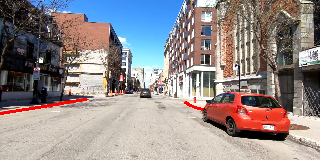

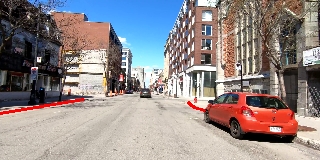

Frame: 500
Polylines: [[[0.3333333333333333, 113.6], [44.333333333333336, 106.2], [78.93333333333334, 100.5], [86.46666666666667, 99.35]], [[202.0, 109.4], [195.46666666666667, 107.35], [190.2, 105.3], [185.0, 102.9]]]
Frame: 501
Polylines: [[[0.3533333333333334, 113.705], [47.406666666666666, 105.83], [77.7, 100.43], [83.28, 99.345]], [[204.60666666666668, 110.295], [194.81333333333336, 107.05], [190.2, 104.98999999999998], [188.82666666666668, 102.80999999999999]]]
Frame 500 predicted:
tensor([  0.5185, 119.4075,  59.3986, 112.8679,  85.4032, 108.8232, 102.3700,
        104.4043, 157.7598, 100.6264, 171.6143, 105.1172, 184.4023, 108.2966,
        193.5469, 109.2142,  -0.8191,  -0.8970,  -0.8576,  -0.9407,  -0.8562,
         -0.9730,  -0.8929,  -0.9711,  -0.9999,  -0.9460,  -0.9460,  -0.8777,
         -0.9449,  -0.9388,  -0.9249,  -0.9618,  -1.0436,  -1.0563,  -1.0406,
         -1.0278,  -1.0334,  -0.8868,  -1.0504,  -0.9326,  -1.0573,  -0.9224,
         -0.8937,  -0.8903,  -0.9431,  

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


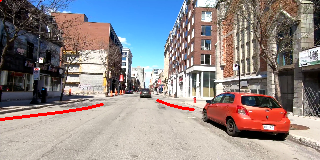

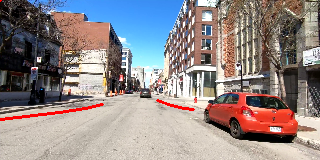

In [31]:
# DEPLOYMENT TEST
from google.colab.patches import cv2_imshow

# TODO: different colors for predicted and ground truth
def draw_polylines(frame, polylines):
  for polyline in polylines:
    polyline = np.array(polyline)
    x, y = polyline.T[0], polyline.T[1]
    frame = cv2.polylines(frame, np.int32([polyline]), False, (0, 0, 255), 2)
  return frame

eval_path = "/content/drive/MyDrive/OpenCRD_dataset/city_2.mp4"
annot_path = "/content/drive/MyDrive/OpenCRD_dataset/city_2_annotations.xml"

frames, annotations = get_data(eval_path, annot_path)
idx = 500

frame1 = cv2.resize(cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB), (W,H))
frame2 = cv2.resize(cv2.cvtColor(frames[idx+1], cv2.COLOR_BGR2RGB), (W,H))
eval_frame1 = cv2.resize(cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB), (W,H))
eval_frame2 = cv2.resize(cv2.cvtColor(frames[idx+1], cv2.COLOR_BGR2RGB), (W,H))
cv2_imshow(draw_polylines(frame1, annotations[idx]))
cv2_imshow(draw_polylines(frame2, annotations[idx+1]))
print("Frame:", idx)
print("Polylines:", annotations[idx])
print("Frame:", idx+1)
print("Polylines:", annotations[idx+1])

# forward to model
X_test1 = np.moveaxis(frame1, -1, 0)
X_test2 = np.moveaxis(frame2, -1, 0)
X_test = []
X_test.append(X_test1)
X_test.append(X_test2)
X_test = np.array(X_test)
X = torch.tensor(X_test).float().to(device)

model.eval()
Y_pred = model(X)
print("Frame", idx, "predicted:")
print(Y_pred[0])
polylines1 = deserialize_polylines(Y_pred[0].cpu().detach().numpy(), model.n_coords, model.n_points, model.max_n_lines)
print(polylines1)
print("Frame", idx+1, "predicted:")
print(Y_pred[1])
polylines2 = deserialize_polylines(Y_pred[1].cpu().detach().numpy(), model.n_coords, model.n_points, model.max_n_lines)
print(polylines2)
cv2_imshow(draw_polylines(eval_frame1, polylines1))
cv2_imshow(draw_polylines(eval_frame2, polylines2))